In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import statsmodels.formula.api as smf
from pycombat import pycombat


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, matthews_corrcoef
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
file_path = 'raw_data_phase_1_07_26_2024 (3).csv'  

df = pd.read_csv(file_path)


In [3]:
def feature(hdata, target_column='plate'):
    """
    Function to compute accuracy and MCC for a given dataset.
    
    Args:
        df (pd.DataFrame): Input dataset.
        target_column (str): Column to use as the target variable (default: 'plate').

    Returns:
        dict: Dictionary with Accuracy and MCC metrics.
    """   
    # Define time and response columns
    time_columns = [f'elapsed_time_{i}' for i in range(2, 82)]
    response_columns = [f'y2_{i}' for i in range(1, 81)]

    def compute_slope(row):
        time_values = row[time_columns].values
        y_values = row[response_columns].values.astype(float)
        mask = ~np.isnan(y_values)  # Handle missing values
        
        if mask.sum() >= 2:  # Ensure at least two valid points
            model = LinearRegression()
            model.fit(time_values[mask].reshape(-1, 1), y_values[mask])
            return model.coef_[0]
        return np.nan
    
    # Compute slope for each row
    hdata['y2_slope'] = hdata.apply(compute_slope, axis=1)

    # Compute additional features
    hdata['y2_mean'] = hdata[[f'y2_{i}' for i in range(1, 81)]].mean(axis=1)
    hdata['y2_variance'] = hdata[[f'y2_{i}' for i in range(1, 81)]].var(axis=1)
    hdata['y2_min'] = hdata[[f'y2_{i}' for i in range(1, 81)]].min(axis=1)
    hdata['y2_max'] = hdata[[f'y2_{i}' for i in range(1, 81)]].max(axis=1)

    # Target variable encoding
   # y = hdata[target_column].astype('category').cat.codes

    # Prepare feature matrix
    features = ['y2_mean', 'y2_variance', 'y2_min', 'y2_max', 'y2_slope','plate']
    feature_df = hdata[features]
    

    psd = compute_psd_features(hdata, time_columns, response_columns)
    psd.index = feature_df.index
    X= pd.concat([feature_df,psd], axis=1)

    
    return X

In [4]:
def random_forest(train_set,test_set):
    t1=feature(train_set)
    t2=feature(test_set)
    features = ['y2_mean', 'y2_variance', 'y2_min', 'y2_max', 'y2_slope','Peak_Frequency']
    X_train=t1[features].values
    X_test=t2[features].values
    y_train=t1['plate']
    # y_train=t1['plate'].astype('category').cat.codes
    y_test=t2['plate']

    model = RandomForestClassifier(random_state=105)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    # print(y_test)
    # print(y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    # Return metrics as a dictionary
    return {"Accuracy": accuracy, "MCC": mcc}

In [5]:
import scipy.signal

def compute_psd_features(df, elapsed_time_cols, y2_cols):
    """
    Computes Power Spectral Density (PSD) features for each mutant in the dataset.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing elapsed time and y2 values for each mutant.
    elapsed_time_cols (list): List of column names corresponding to elapsed time.
    y2_cols (list): List of column names corresponding to y2 values.

    Returns:
    pd.DataFrame: DataFrame containing PSD features (Peak Frequency, Total Power, Spectral Entropy) for each mutant.
    """
    from scipy.signal import welch
    from scipy.stats import entropy

    psd_features = []

    for index, row in df.iterrows():
        # Extract elapsed time and y2 values

        elapsed_time = row[elapsed_time_cols].dropna().values.astype(float)
        y2_values = row[y2_cols].dropna().values.astype(float)

        # Compute sampling frequency (fs) dynamically
        time_diffs = np.diff(elapsed_time)
        fs = 1 / np.mean(time_diffs) if np.mean(time_diffs) > 0 else 1  # Prevent division by zero

        # Compute PSD using Welch’s method
        frequencies, psd_values = welch(y2_values, fs, nperseg=min(256, len(y2_values)))
        # frequencies, psd_values = scipy.signal.periodogram(y2_values, fs, scaling='density')

        # Extract PSD features
        peak_freq = frequencies[np.argmax(psd_values)] if len(frequencies) > 0 else 0  # Peak frequency
        # total_power = np.sum(psd_values)  # Total power
        # psd_norm = psd_values / np.sum(psd_values) if np.sum(psd_values) > 0 else np.ones_like(psd_values)
        # spectral_entropy = entropy(psd_norm)  # Spectral entropy
        psd_features.append([peak_freq])

        # psd_features.append([peak_freq, total_power, spectral_entropy])
    

    # Convert to DataFrame
    # psd_df = pd.DataFrame(psd_features, columns=["Peak_Frequency", "Total_Power", "Spectral_Entropy"])
    psd_df = pd.DataFrame(psd_features, columns=["Peak_Frequency"])

    return psd_df


In [37]:
import pandas as pd
import numpy as np
from sklearn.metrics import matthews_corrcoef, accuracy_score

# Function to split WT rows into "keep" (test) and "holdout" (train) randomly
def split_wt_rows(group):
    wt_rows = group[group['mutant_ID'] == 'WT']

    if len(wt_rows) > 1:
        test_row = wt_rows.sample(n=1)  # Randomly select one WT row for test
        train_rows = wt_rows.drop(test_row.index)  # Remaining WT rows for training
        return test_row, train_rows
    return pd.DataFrame(), pd.DataFrame()

# Initialize lists to store MCC and accuracy results
mcc_scores = []
accuracy_scores = []

num_iterations = 100  # Number of iterations

for _ in range(num_iterations):
    keep_list = []
    holdout_list = []

    # Group by 'plate' and 'light_regime', and apply the split function
    for plate_measure, group in df.groupby(['plate', 'light_regime']):
        
        if plate_measure[0] != 99:
            keep, holdout = split_wt_rows(group)
          
            keep_list.append(keep)
            holdout_list.append(holdout)

    # Concatenate results
    test_set = pd.concat(keep_list).reset_index(drop=True)
    train_set = pd.concat(holdout_list).reset_index(drop=True)

    result = random_forest(train_set, test_set)
    accuracy_scores.append(result["Accuracy"])
    mcc_scores.append(result["MCC"])


# Compute average MCC and accuracy over 100 runs
avg_mcc = np.mean(mcc_scores)
avg_accuracy = np.mean(accuracy_scores)

print("Average MCC:", avg_mcc)
print("Average Accuracy:", avg_accuracy)


In [287]:

classificaiton_WT(df)

Average MCC: 0.49338923522873207
Average Accuracy: 0.5143511450381679


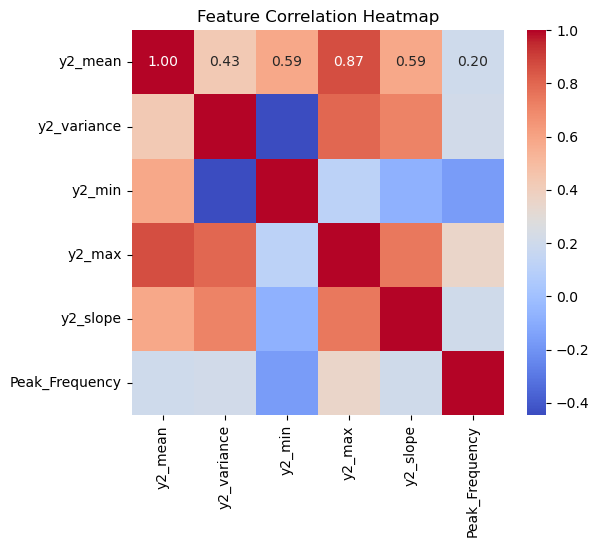

In [15]:
heatmap_plot(df)

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# only for no removal
def perform_pca_and_plot(df):
    # Step 1: Select numerical features for PCA
    features = ['y2_mean', 'y2_variance', 'y2_min', 'y2_max', 'y2_slope','Peak_Frequency']
    X = df[features].values
    y = df['plate'].values.astype(str)  
    
    # print(y)  # Debugging check

    # Step 2: Standardize features before PCA
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Step 3: Apply PCA to reduce to 2 dimensions
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # Step 4: Convert results into a DataFrame
    pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
    pca_df['Plate'] = y 
    print(pca_df.head())  # Debugging check

    # Step 5: Plot PCA results with color-coded plates
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='PC1', y='PC2', hue='Plate', palette='tab10', data=pca_df, alpha=0.8) 
    plt.title("PCA Projection of Features (Colored by Plate)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title="Plate", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()



        PC1       PC2 Plate
0 -0.326474 -0.346454     2
1 -0.464107 -0.506843     2
2 -0.346343 -0.793794     2
3  3.842786 -1.578105     2
4  3.637418 -1.683826     2


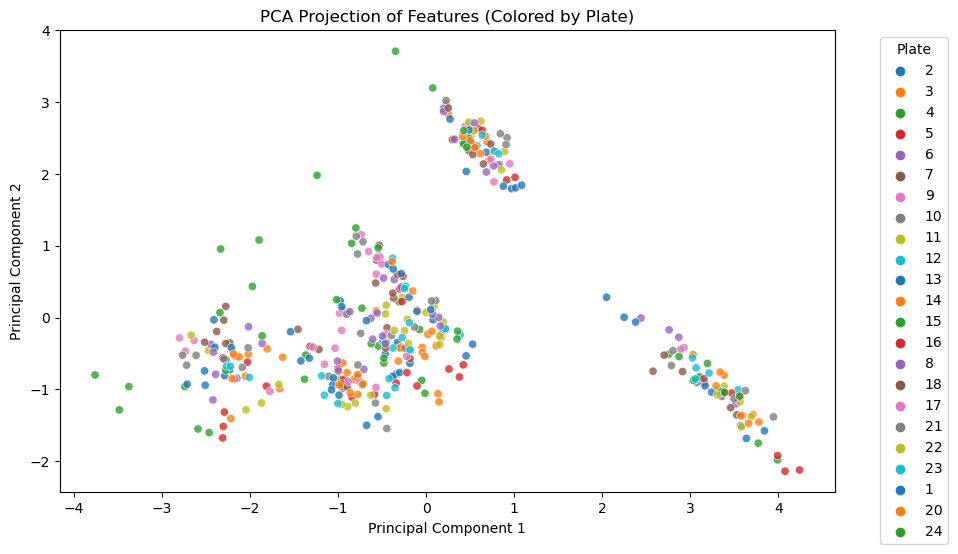

In [246]:
perform_pca_and_plot(X_original)

        PC1       PC2 Plate
0 -0.611241 -0.578455     2
1 -0.749277 -0.727584     2
2 -0.639647 -1.015087     2
3  3.942784 -1.584404     2
4  3.741674 -1.671873     2


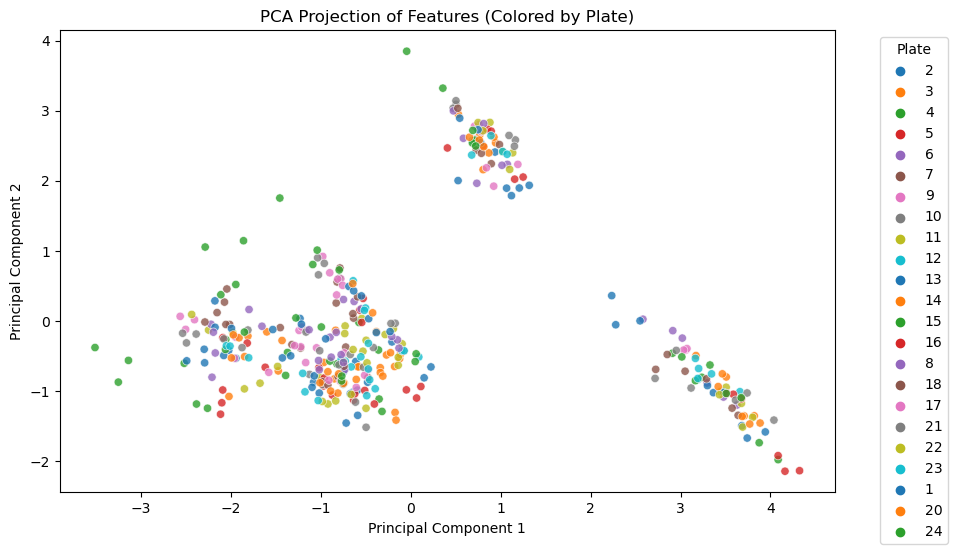

In [275]:
perform_pca_and_plot(X_original)

In [269]:
def random_forest(train_set,test_set):
    t1=feature(train_set)
    t2=feature(test_set)
    features = ['y2_mean', 'y2_variance', 'y2_min', 'y2_max', 'y2_slope','Peak_Frequency']
    X_train=t1[features].values
    X_test=t2[features].values
    y_train=t1['plate']
    y_test=t2['plate']

    model = RandomForestClassifier(random_state=105)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    # Return metrics as a dictionary
    return {"Accuracy": accuracy, "MCC": mcc}

In [45]:
def split_wt_rows1(group,seed):
    wt_rows = group[group['mutant_ID'] == 'WT']

    if len(wt_rows) > 1:
        test_row = wt_rows.sample(n=1,random_state=seed)  # Randomly select one WT row for test
        train_rows = wt_rows.drop(test_row.index)  # Remaining WT rows for training
        return test_row, train_rows
    return pd.DataFrame(), pd.DataFrame()

def random_forest_result(train_set,test_set):
    t1=feature(train_set)
    t2=feature(test_set)
    features = ['y2_mean', 'y2_variance', 'y2_min', 'y2_max', 'y2_slope','Peak_Frequency']
    X_train=t1[features].values
    X_test=t2[features].values
    y_train=t1['plate']
    y_test=t2['plate']

    model = RandomForestClassifier(random_state=105)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)


    

    # feature importance
    feature_importances = model.feature_importances_
    importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by="Importance", ascending=False)
    plt.figure(figsize=(8, 5))
    sns.barplot(x=importance_df['Importance'], y=importance_df['Feature'], palette="viridis")
    plt.xlabel("Feature Importance Score")
    plt.ylabel("Features")
    plt.title("Feature Importance - Random Forest")
    plt.show()


    # confusion matrix
    unique_labels = sorted(np.unique(y_test))  
    cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
    plt.figure(figsize=(8, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    

    accuracy = accuracy_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    return {"Accuracy": accuracy, "MCC": mcc}
    
def result(data, num_iterations = 1):
    
    mcc_scores = []
    accuracy_scores = []

  
    for _ in range(1):
        keep_list = []
        holdout_list = []
        for plate_measure, group in data.groupby(['plate', 'light_regime']):
            if plate_measure[0] != 99:
                keep, holdout = split_wt_rows1(group,10)
                keep_list.append(keep)
                holdout_list.append(holdout)
        test_set = pd.concat(keep_list).reset_index(drop=True)
        train_set = pd.concat(holdout_list).reset_index(drop=True)


        result = random_forest_result(train_set, test_set)

    print(result)


In [261]:
data_WT=df[df['mutant_ID']=='WT']
data_WT=data_WT[data_WT['plate']!=99]


In [288]:
feature(data_WT)

,y2_mean,y2_variance,y2_min,y2_max,y2_slope,plate,Peak_Frequency
827,0.362949,0.020704,0.184086,0.537680,0.000056,2,1.993132
1099,0.364755,0.021722,0.169362,0.547512,0.000397,2,1.993132
1119,0.352185,0.022421,0.147085,0.531104,0.000501,2,1.993132
1232,0.141938,0.001437,0.091892,0.235280,-0.005191,2,0.050606
1504,0.141871,0.001507,0.086624,0.235591,-0.003998,2,0.050606
...,...,...,...,...,...,...,...
54777,0.399621,0.012329,0.269798,0.528745,0.000697,20,1.987005
55048,0.376366,0.013174,0.238018,0.513301,0.000445,20,1.987005
55091,0.428979,0.038081,0.209551,0.632449,-0.000759,1,0.998511
55092,0.412236,0.037803,0.175868,0.617467,-0.000899,1,0.998511


In [263]:
data_SVD_WT=data_SVD[data_SVD['mutant_ID']=='WT']
data_SVD_WT=data_SVD_WT[data_SVD_WT['plate']!=99]


In [289]:
feature(data_SVD_WT)

,y2_mean,y2_variance,y2_min,y2_max,y2_slope,plate,Peak_Frequency
827,0.375805,0.014022,0.193726,0.567311,-0.000249,2,1.993132
1099,0.378101,0.014500,0.166684,0.562511,0.000080,2,1.993132
1119,0.365615,0.015596,0.160348,0.560851,0.000182,2,1.993132
1232,0.374037,0.015740,0.173540,0.561844,-0.000451,3,1.989757
1501,0.382193,0.016479,0.167943,0.582196,-0.001591,3,1.989757
...,...,...,...,...,...,...,...
54895,0.348055,0.044434,0.081894,0.578967,0.003220,24,0.253031
54934,0.346686,0.041945,0.101857,0.572328,0.002595,24,0.253031
55174,0.291725,0.003509,0.201574,0.398409,-0.007701,21,0.253024
55453,0.291648,0.003205,0.210355,0.396866,-0.006933,21,0.253024


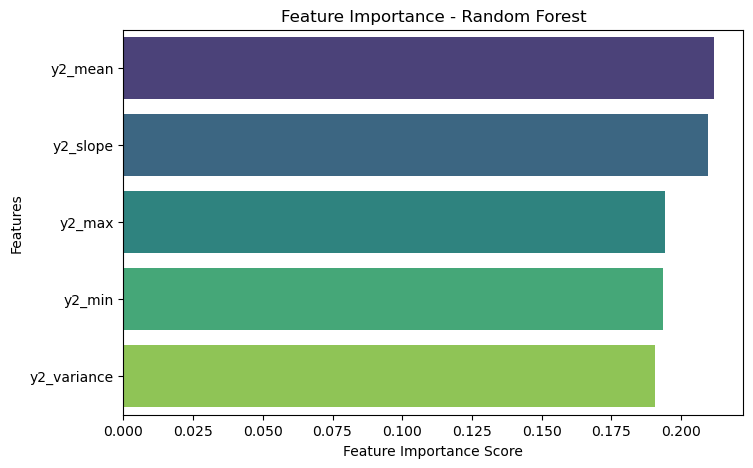

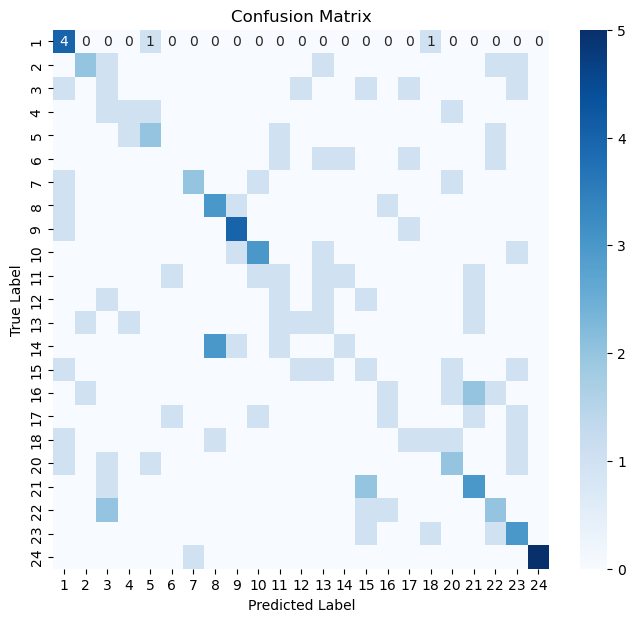

{'Accuracy': 0.3282442748091603, 'MCC': 0.29795265680896815}


In [270]:
result(df)

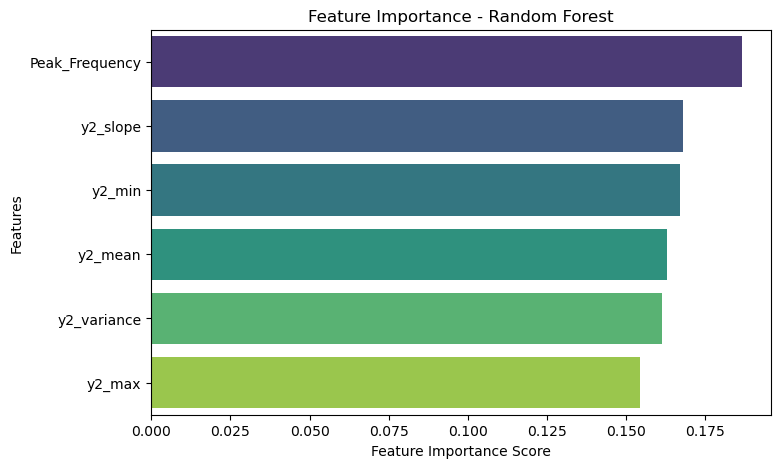

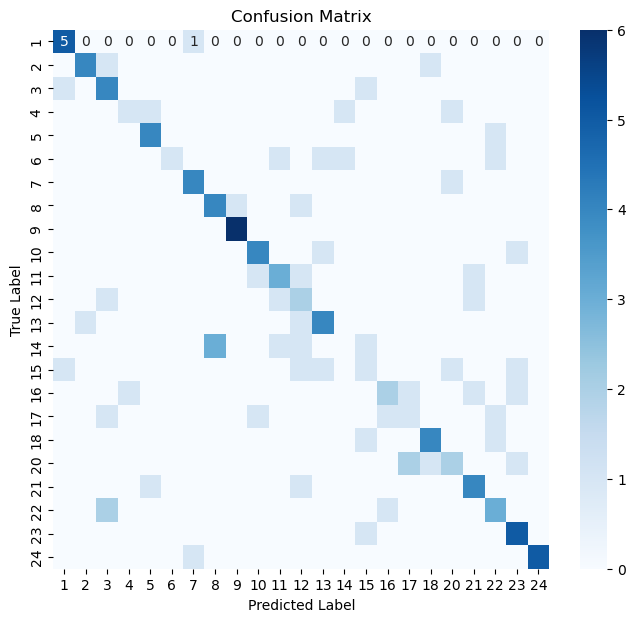

{'Accuracy': 0.5572519083969466, 'MCC': 0.5381344312510011}


In [272]:
result(df)

## SVD

In [8]:
def classificaiton_WT(data, num_iterations = 100):
    
    mcc_scores = []
    accuracy_scores = []

  
    for _ in range(num_iterations):
        keep_list = []
        holdout_list = []
        for plate_measure, group in data.groupby(['plate', 'light_regime']):
            if plate_measure[0] != 99:
                keep, holdout = split_wt_rows(group)
                keep_list.append(keep)
                holdout_list.append(holdout)
        test_set = pd.concat(keep_list).reset_index(drop=True)
        train_set = pd.concat(holdout_list).reset_index(drop=True)
        result = random_forest(train_set, test_set)
        accuracy_scores.append(result["Accuracy"])
        mcc_scores.append(result["MCC"])
        
    avg_mcc = np.mean(mcc_scores)
    avg_accuracy = np.mean(accuracy_scores)

    print("Average MCC:", avg_mcc)
    print("Average Accuracy:", avg_accuracy)



    

In [9]:
data_SVD = pd.read_csv('SVD_new.csv')

In [11]:

def heatmap_plot(data):
    wt = data [data ['mutant_ID'] == 'WT'].copy()
    wt=wt[wt['plate']!=99]
    X=feature(wt)
    X = X.drop(columns=["plate"])
    
    corr_matrix = X.corr()
    plt.figure(figsize=(6, 5))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Feature Correlation Heatmap")
    plt.show()

    

In [31]:
def perform_pca_and_plot(data):
    wt = data[data ['mutant_ID'] == 'WT'].copy()
    wt=wt[wt['plate']!=99]
    df=feature(wt)

    # Step 1: Select numerical features for PCA
    features = ['y2_mean', 'y2_variance', 'y2_min', 'y2_max', 'y2_slope','Peak_Frequency']
    X = df[features].values
    y = df['plate'].values.astype(str)  
    
    # print(y)  # Debugging check

    # Step 2: Standardize features before PCA
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Step 3: Apply PCA to reduce to 2 dimensions
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # Step 4: Convert results into a DataFrame
    pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
    pca_df['Plate'] = y  

    # Step 5: Plot PCA results with color-coded plates
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='PC1', y='PC2', hue='Plate', palette='tab10', data=pca_df, alpha=0.8)  # ✅ Use 'tab10' for categorical labels
    plt.title("PCA Projection of Features (Only WT)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title="Plate", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

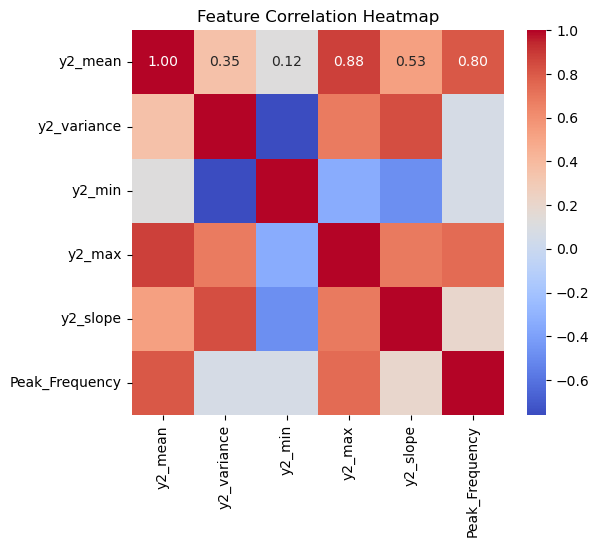

In [14]:
heatmap_plot(data_SVD)

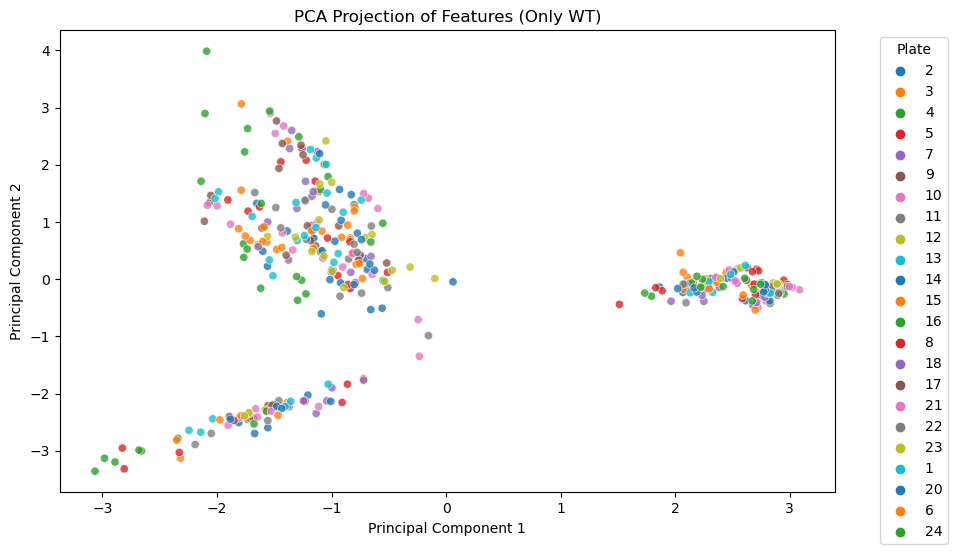

In [32]:
perform_pca_and_plot(data_SVD)

In [301]:
X_original

,y2_mean,y2_variance,y2_min,y2_max,y2_slope,plate,Peak_Frequency
827,0.362949,0.020704,0.184086,0.537680,0.000056,2,1.993132
1099,0.364755,0.021722,0.169362,0.547512,0.000397,2,1.993132
1119,0.352185,0.022421,0.147085,0.531104,0.000501,2,1.993132
1232,0.141938,0.001437,0.091892,0.235280,-0.005191,2,0.050606
1504,0.141871,0.001507,0.086624,0.235591,-0.003998,2,0.050606
...,...,...,...,...,...,...,...
54777,0.399621,0.012329,0.269798,0.528745,0.000697,20,1.987005
55048,0.376366,0.013174,0.238018,0.513301,0.000445,20,1.987005
55091,0.428979,0.038081,0.209551,0.632449,-0.000759,1,0.998511
55092,0.412236,0.037803,0.175868,0.617467,-0.000899,1,0.998511


In [302]:
data_SVD

,y2_1,y2_2,y2_3,y2_4,y2_5,y2_6,y2_7,y2_8,y2_9,y2_10,...,elapsed_time_73,elapsed_time_74,elapsed_time_75,elapsed_time_76,elapsed_time_77,elapsed_time_78,elapsed_time_79,elapsed_time_80,elapsed_time_81,light_regime
0,0.370014,0.460426,0.231421,0.567164,0.323294,0.457258,0.193308,0.564001,0.342623,0.436677,...,18.554167,18.571111,19.054722,19.071667,19.555278,19.572222,20.056944,20.073889,20.329722,1min-1min
1,0.348125,0.442737,0.234127,0.555001,0.328023,0.404031,0.234283,0.555353,0.358037,0.420842,...,18.554167,18.571111,19.054722,19.071667,19.555278,19.572222,20.056944,20.073889,20.329722,1min-1min
2,0.342679,0.433564,0.246860,0.530723,0.327358,0.434874,0.225201,0.538051,0.358800,0.417534,...,18.554167,18.571111,19.054722,19.071667,19.555278,19.572222,20.056944,20.073889,20.329722,1min-1min
3,0.340775,0.419223,0.219493,0.535295,0.324585,0.406273,0.199348,0.534483,0.319913,0.399981,...,18.554167,18.571111,19.054722,19.071667,19.555278,19.572222,20.056944,20.073889,20.329722,1min-1min
4,0.314920,0.428705,0.242634,0.552833,0.327286,0.422221,0.233100,0.544830,0.328874,0.411528,...,18.554167,18.571111,19.054722,19.071667,19.555278,19.572222,20.056944,20.073889,20.329722,1min-1min
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55509,0.408515,0.371996,0.353920,0.360350,0.330177,0.332005,0.304735,0.308433,0.363043,0.343802,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20h_ML
55510,0.367060,0.384835,0.367222,0.402322,0.336991,0.302426,0.328691,0.305361,0.355001,0.353719,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20h_ML
55511,0.336303,0.334450,0.330199,0.332625,0.346976,0.350334,0.331781,0.304517,0.325287,0.315586,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20h_ML
55512,0.349108,0.350709,0.322636,0.344941,0.334979,0.336065,0.314105,0.308530,0.337792,0.331095,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20h_ML


In [286]:
classificaiton_WT(data_SVD,100)

Average MCC: 0.4367166330924493
Average Accuracy: 0.46007633587786256


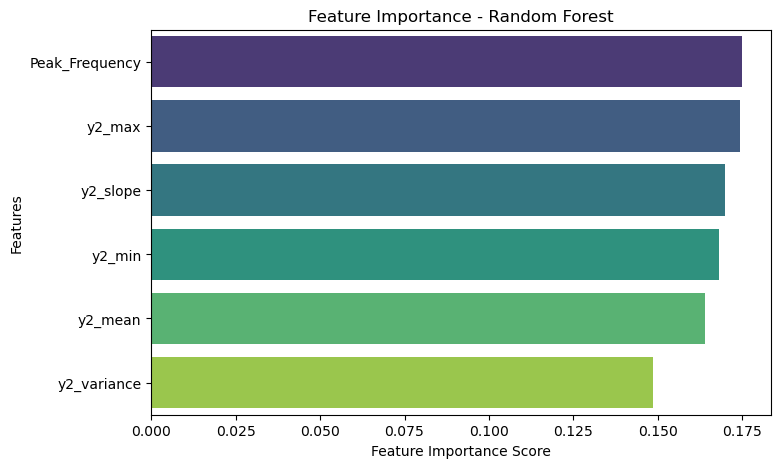

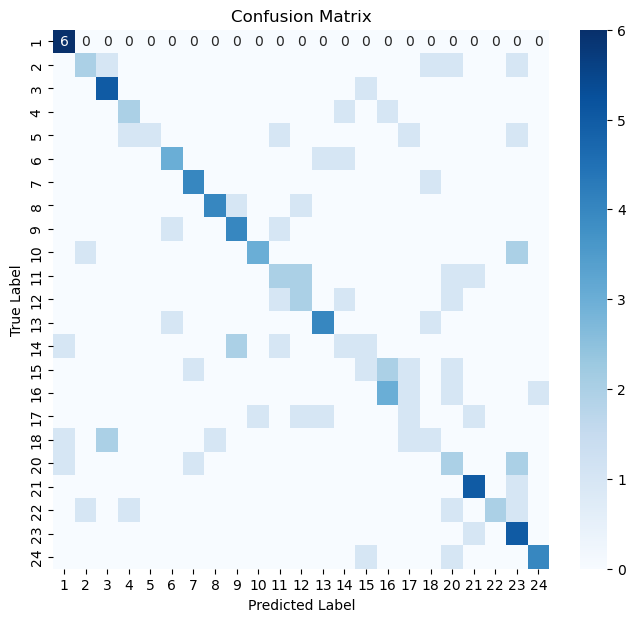

{'Accuracy': 0.5114503816793893, 'MCC': 0.4909467237427875}


In [290]:
result(data_SVD)

## Combat

In [39]:
#combat
data_combat = pd.read_csv('combat.csv')


In [44]:
classificaiton_WT(data_combat)

Average MCC: 0.5389778079277395
Average Accuracy: 0.5576335877862595


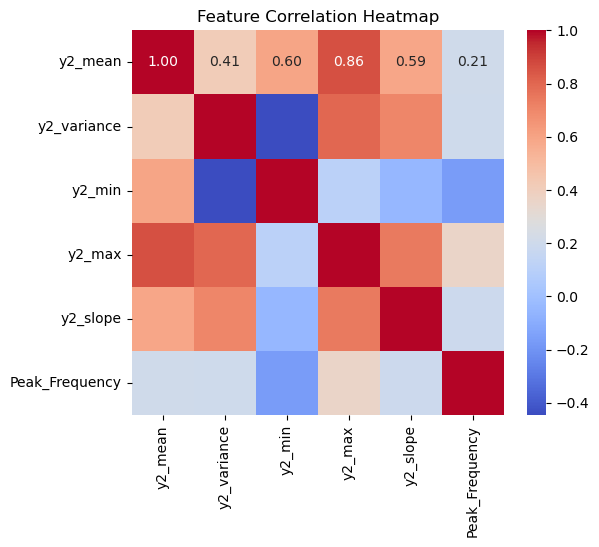

In [40]:
heatmap_plot(data_combat)

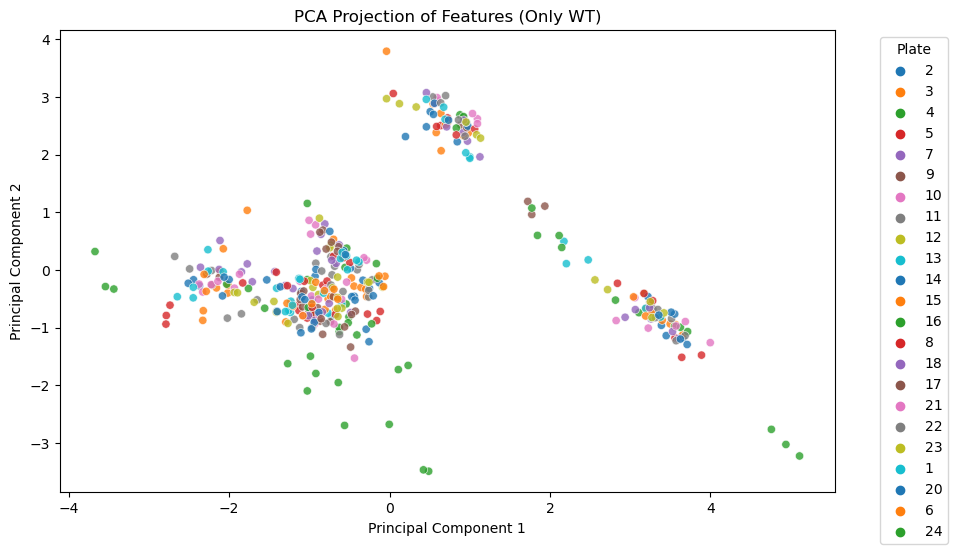

In [41]:
perform_pca_and_plot(data_combat)

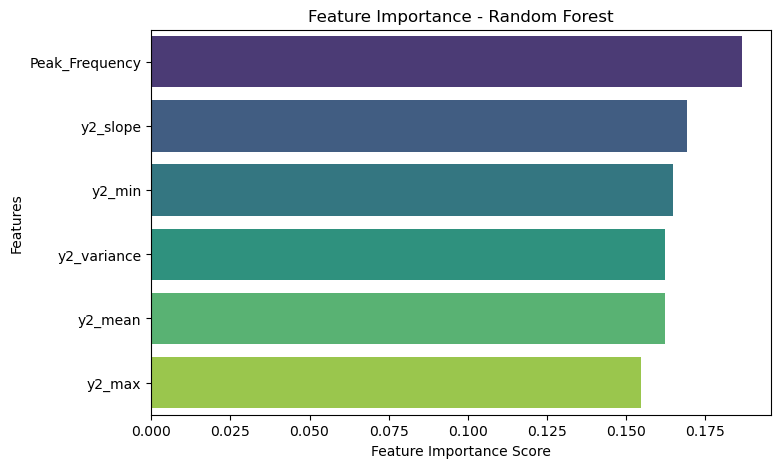

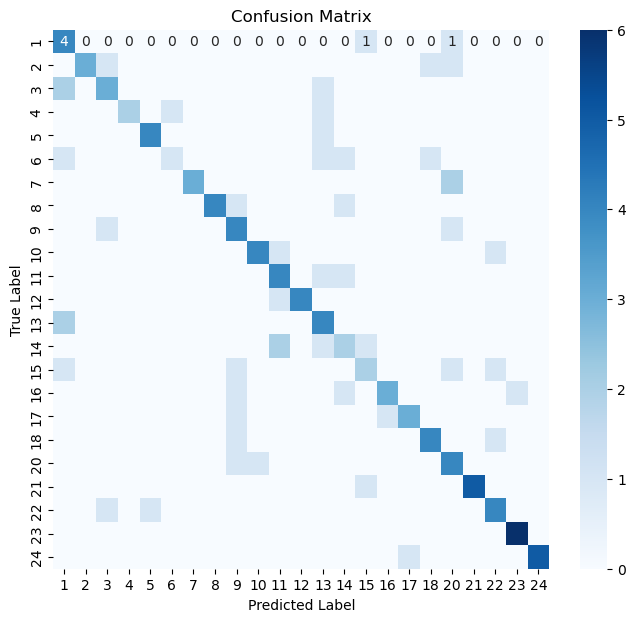

{'Accuracy': 0.6259541984732825, 'MCC': 0.6105789607140009}


In [46]:
result(data_combat)

## Removing the WT mean

In [ ]:
#WT
data_WTmean = pd.read_csv('WT_mean.csv')
classificaiton_WT(data_WTmean)

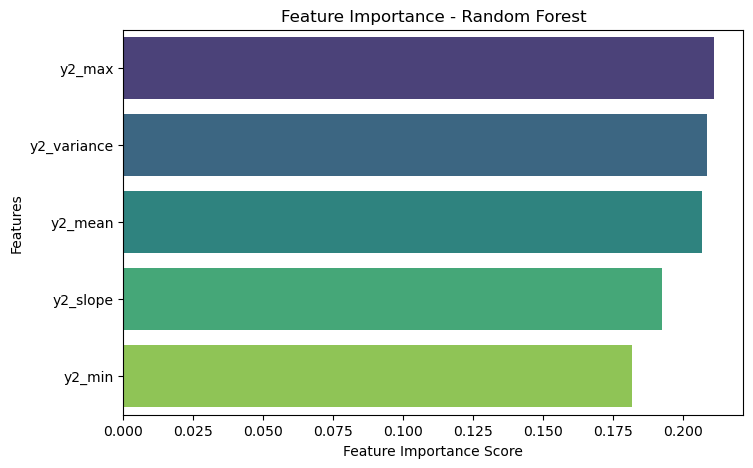

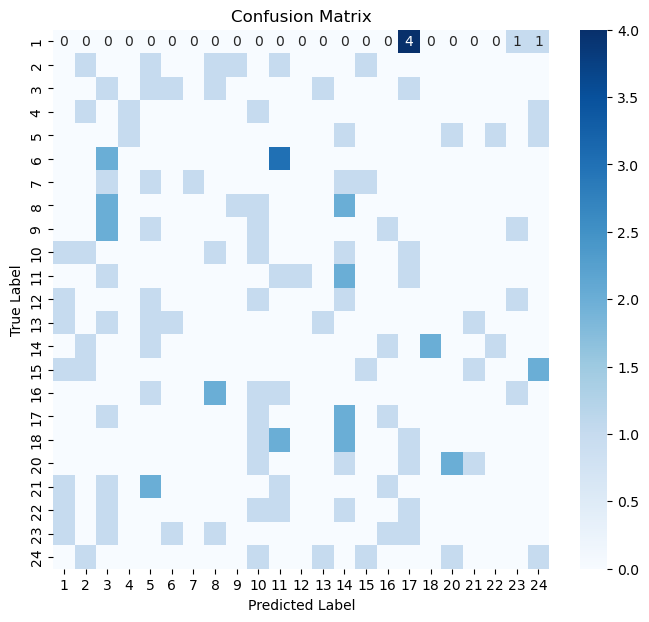

{'Accuracy': 0.08396946564885496, 'MCC': 0.04220833028479912}


In [202]:
result(data_WTmean)

## Friedman Rafsky test

In [23]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import minimum_spanning_tree
import random

def friedman_rafsky_test(features, labels, num_permutations=1000):
    """
    Perform Friedman-Rafsky test.
    
    Args:
        features (numpy.ndarray): A 2D array of feature data (rows = samples, columns = features).
        labels (list or numpy.ndarray): Group labels for each sample.
        num_permutations (int): Number of permutations for the test.
        
    Returns:
        observed_stat (int): Observed number of pure edges.
        p_value (float): P-value from the permutation test.
    """
    # Step 1: Compute the distance matrix
    dist_matrix = squareform(pdist(features, metric='euclidean'))

    # Step 2: Build the MST
    mst = minimum_spanning_tree(dist_matrix).toarray()

    # Step 3: Count pure edges in the MST
    def count_pure_edges(mst, labels):
        pure_edges = 0
        for i in range(mst.shape[0]):
            for j in range(i + 1, mst.shape[1]):
                if mst[i, j] > 0 and labels[i] == labels[j]:
                    pure_edges += 1
        return pure_edges

    observed_stat = count_pure_edges(mst, labels)

    # Step 4: Permutation Test
    permuted_stats = []
    for _ in range(num_permutations):
        permuted_labels = random.sample(labels, len(labels))
        permuted_stat = count_pure_edges(mst, permuted_labels)
        permuted_stats.append(permuted_stat)

    #print('number greater than observed',(np.sum(np.array(permuted_stats) >= observed_stat) + 1) )
    # print(permuted_stats)
    p_value = (np.sum(np.array(permuted_stats) >= observed_stat) + 1) / (num_permutations + 1)

    return observed_stat, p_value

In [24]:
# No removal
data=df[df['plate']!=99]
data_WT=data[data['mutant_ID']=='WT'].copy()
fea = feature(data_WT, target_column='plate')
labels=list(fea['plate'])
f = ['y2_mean', 'y2_variance', 'y2_min', 'y2_max', 'y2_slope','Peak_Frequency']
features=np.array(fea[f])

observed_stat, p_value = friedman_rafsky_test(features, labels, num_permutations=1000)
print(f"Observed Statistic: {observed_stat}")
print(f"P-value: {p_value}")

Observed Statistic: 60
P-value: 0.000999000999000999


In [25]:
# SVD
data=data_SVD[data_SVD['plate']!=99]
data_WT=data[data['mutant_ID']=='WT'].copy()
fea = feature(data_WT, target_column='plate')
labels=list(fea['plate'])
f = ['y2_mean', 'y2_variance', 'y2_min', 'y2_max', 'y2_slope','Peak_Frequency']
features=np.array(fea[f])

observed_stat, p_value = friedman_rafsky_test(features, labels, num_permutations=1000)
print(f"Observed Statistic: {observed_stat}")
print(f"P-value: {p_value}")

Observed Statistic: 34
P-value: 0.000999000999000999
